In [1]:
import os
import umap
from dotenv import load_dotenv
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from embeddings import EmbeddingsDataset

/home/kmorhun/.conda/envs/stacky-sae/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Recalculating embeddings from Milvus, if needed

In [2]:
# Load dataset
embeddings_dir = Path(os.environ.get("EMBEDDINGS_FOLDER"))
path = embeddings_dir / "full_cleaned"
dataset = EmbeddingsDataset()
dataset.load_all_embeddings(dir=path, from_dir=True)


(tensor([[ 0.0059, -0.0006,  0.0087,  ..., -0.0003, -0.0255, -0.0369],
         [-0.0277, -0.0146, -0.0183,  ..., -0.0139,  0.0334, -0.0065],
         [ 0.0262, -0.0238,  0.0157,  ...,  0.0262,  0.0549,  0.0085],
         ...,
         [ 0.0254, -0.0263, -0.0405,  ...,  0.0190, -0.0018,  0.0227],
         [-0.0151,  0.0044,  0.0399,  ..., -0.0110, -0.0510,  0.0048],
         [ 0.0371,  0.0565,  0.0536,  ..., -0.0150, -0.0043, -0.0108]]),
                          id                                               text
 0                 646107512  New server, new #introductionI've been on blah...
 1         86343507941150720                                        post a gain
 2         98283364230408003  <p>I don&#39;t want my main Mastodon account t...
 3         98630262120204439  <p><a href="https://octodon.social/media/qxAWo...
 4         98639560353995269                           <p>everything broked</p>
 ...                     ...                                                ..

In [3]:
print(len(dataset))
print(dataset.metadata.shape)

114411
(114411, 2)


In [34]:
import pandas as pd
metadata_path = embeddings_dir / "full_cleaned" / "metadata.csv"
metadata = pd.read_csv(metadata_path)
metadata.shape

(114411, 2)

In [41]:
# from pymilvus import MilvusClient, Collection, connections

"""
spot check many ids to see 
- if the text matched up with a vector in the EmbeddingsDataset is the same as in milvus
- if the post exists in mastodon
"""
indices_to_check = np.arange(0, len(dataset), 1000)
dataset_query = dataset[indices_to_check]
print(dataset_query.keys())


dict_keys(['embedding', 'id', 'text'])


In [44]:
import torch
dataset.load_all_partitions()

cosi = torch.nn.CosineSimilarity(dim=0) 
results = []

for i, index in enumerate(indices_to_check):
    embedding = dataset_query['embedding'][i]
    mastodon_id = dataset_query['id'].reset_index(drop=True)[i]
    text = dataset_query['text'].reset_index(drop=True)[i]
    
    milvus_response = dataset.get_from_milvus(ids=[mastodon_id])[0]
    milvus_id = milvus_response['id']
    milvus_embedding = milvus_response['text_vector']
    milvus_text = milvus_response['text']
    # print(milvus_response)
    distance = cosi(embedding, torch.FloatTensor(milvus_embedding))
    print(f"dataset id {mastodon_id} milvus id {milvus_id}")
    print(f"dataset text {text}")
    print(f"milvus text {milvus_text}")
    print(f"distance {distance}")

    new_row = {'dataset_id': mastodon_id, 'milvus_id': milvus_id, 'dataset_text': text, 'milvus_text': milvus_text, 'similarity': distance}
    results.append(new_row)

results_df = pd.DataFrame(results)

dataset id 646107512 milvus id 646107512
dataset text New server, new #introductionI've been on blahaj.zone for a decent bit, but now I'm self-hosting out of reliability concerns. Looking forward to futzing about with this some more!I write a lot and show most of it to no one. I'm a leftist. I'm a fan of all furry critters and plenty that aren't. Neurospicy. Very strong opinions on accessibility, especially that no one's needs are universal. Tech-focused, but I wish we could stop building anew so much and focus on a reliable, stable core that we can expand on for decades or centuries to come.No one is free until all of us are free.
milvus text New server, new #introductionI've been on blahaj.zone for a decent bit, but now I'm self-hosting out of reliability concerns. Looking forward to futzing about with this some more!I write a lot and show most of it to no one. I'm a leftist. I'm a fan of all furry critters and plenty that aren't. Neurospicy. Very strong opinions on accessibility, es

In [45]:
results_df

,dataset_id,milvus_id,dataset_text,milvus_text,similarity
0,646107512,646107512,"New server, new #introductionI've been on blah...","New server, new #introductionI've been on blah...",tensor(1.)
1,106021905686114894,106021905686114894,"<p><a href=""https://monads.online/tags/introdu...","<p><a href=""https://monads.online/tags/introdu...",tensor(1.)
2,108883364007626044,108883364007626044,thursday 25 august: 5/42: 15m run🪺 buzzwords o...,thursday 25 august: 5/42: 15m run🪺 buzzwords o...,tensor(1.)
3,109338954062755469,109338954062755469,"<p><a href=""https://social.sciences.re/tags/in...","<p><a href=""https://social.sciences.re/tags/in...",tensor(1.)
4,109486967079552310,109486967079552310,"<p>What else? I’m also a big <a href=""https://...","<p>What else? I’m also a big <a href=""https://...",tensor(1.)
...,...,...,...,...,...
110,112880055694775976,112880055694775976,I wonder if Vance believes that Peter Thiel i...,I wonder if Vance believes that Peter Thiel i...,tensor(1.)
111,112880106233300236,112880106233300236,lol bro. Welcome to the 30s in North America....,lol bro. Welcome to the 30s in North America....,tensor(1.)
112,112880195692939053,112880195692939053,Harris just graduated from the 4-year How-to-...,Harris just graduated from the 4-year How-to-...,tensor(1.)
113,112880231345634245,112880231345634245,"@TK I retired recently after a long career, w...","@TK I retired recently after a long career, w...",tensor(1.)


In [46]:
results_df[results_df['dataset_id'] != results_df['milvus_id']] #should be empty

,dataset_id,milvus_id,dataset_text,milvus_text,similarity


In [48]:
results_df[results_df['dataset_text'] != results_df['milvus_text']] # should be empty
#ok, it's not, but that's probably because of newlines and tabs, so it's all good

,dataset_id,milvus_id,dataset_text,milvus_text,similarity
77,112794098866056134,112794098866056134,"@doc, just fyi, the article mentions that. ""L...","@doc, just fyi, the article mentions that.\n\n...",tensor(1.)
82,112853816140021609,112853816140021609,"Democrats, calm down and take a deep breath. I...","Democrats, calm down and take a deep breath. I...",tensor(1.)
86,112854098433450896,112854098433450896,"@BChad I agree with everything you said, exce...","@BChad\n\nI agree with everything you said, ex...",tensor(1.)
89,112854361950584522,112854361950584522,@Ana: There is no living with a true zero carb...,@Ana: There is no living with a true zero carb...,tensor(1.)
90,112854437411092148,112854437411092148,@coale johnson Attacks are not ideas or polic...,@coale johnson \nAttacks are not ideas or poli...,tensor(1.)
97,112857520415097702,112857520415097702,It’s like Trump only sticks those idiots behin...,It’s like Trump only sticks those idiots behin...,tensor(1.)
102,112877672128967091,112877672128967091,"“I will always love you, but I really do think...","“I will always love you, but I really do think...",tensor(1.)
104,112878574414047903,112878574414047903,"Everywhere man goes, and I do mean ""man"", he ...","Everywhere man goes, and I do mean ""man"", he ...",tensor(1.)
108,112879944115954232,112879944115954232,Cooler housing and affordable cool roof optio...,Cooler housing and affordable cool roof optio...,tensor(1.)
110,112880055694775976,112880055694775976,I wonder if Vance believes that Peter Thiel i...,I wonder if Vance believes that Peter Thiel i...,tensor(1.)


In [49]:
results_df[results_df['similarity'] != torch.tensor([1.])] # should be empty

,dataset_id,milvus_id,dataset_text,milvus_text,similarity


# Visualizing input embedings

In [ ]:
load = True # change to False to recalculate umap embeddings of data

In [2]:
# Load dataset
embeddings_dir = Path(os.environ.get("EMBEDDINGS_FOLDER"))
path = embeddings_dir / "full"
dataset = EmbeddingsDataset()
dataset.load_all_embeddings(dir=path, from_dir=True)


In [ ]:
umap_path = embeddings_dir / f"embeddings_umap.npy"
if not load:
    # Apply UMAP
    umap_model = umap.UMAP(n_neighbors=7, min_dist=0.3, n_components=2)
    embeddings_umap = umap_model.fit_transform(dataset.embeddings)
    # save embeddings to numpy file
    np.save(umap_path, embeddings_umap)
else:
    embeddings_umap = np.load(umap_path)

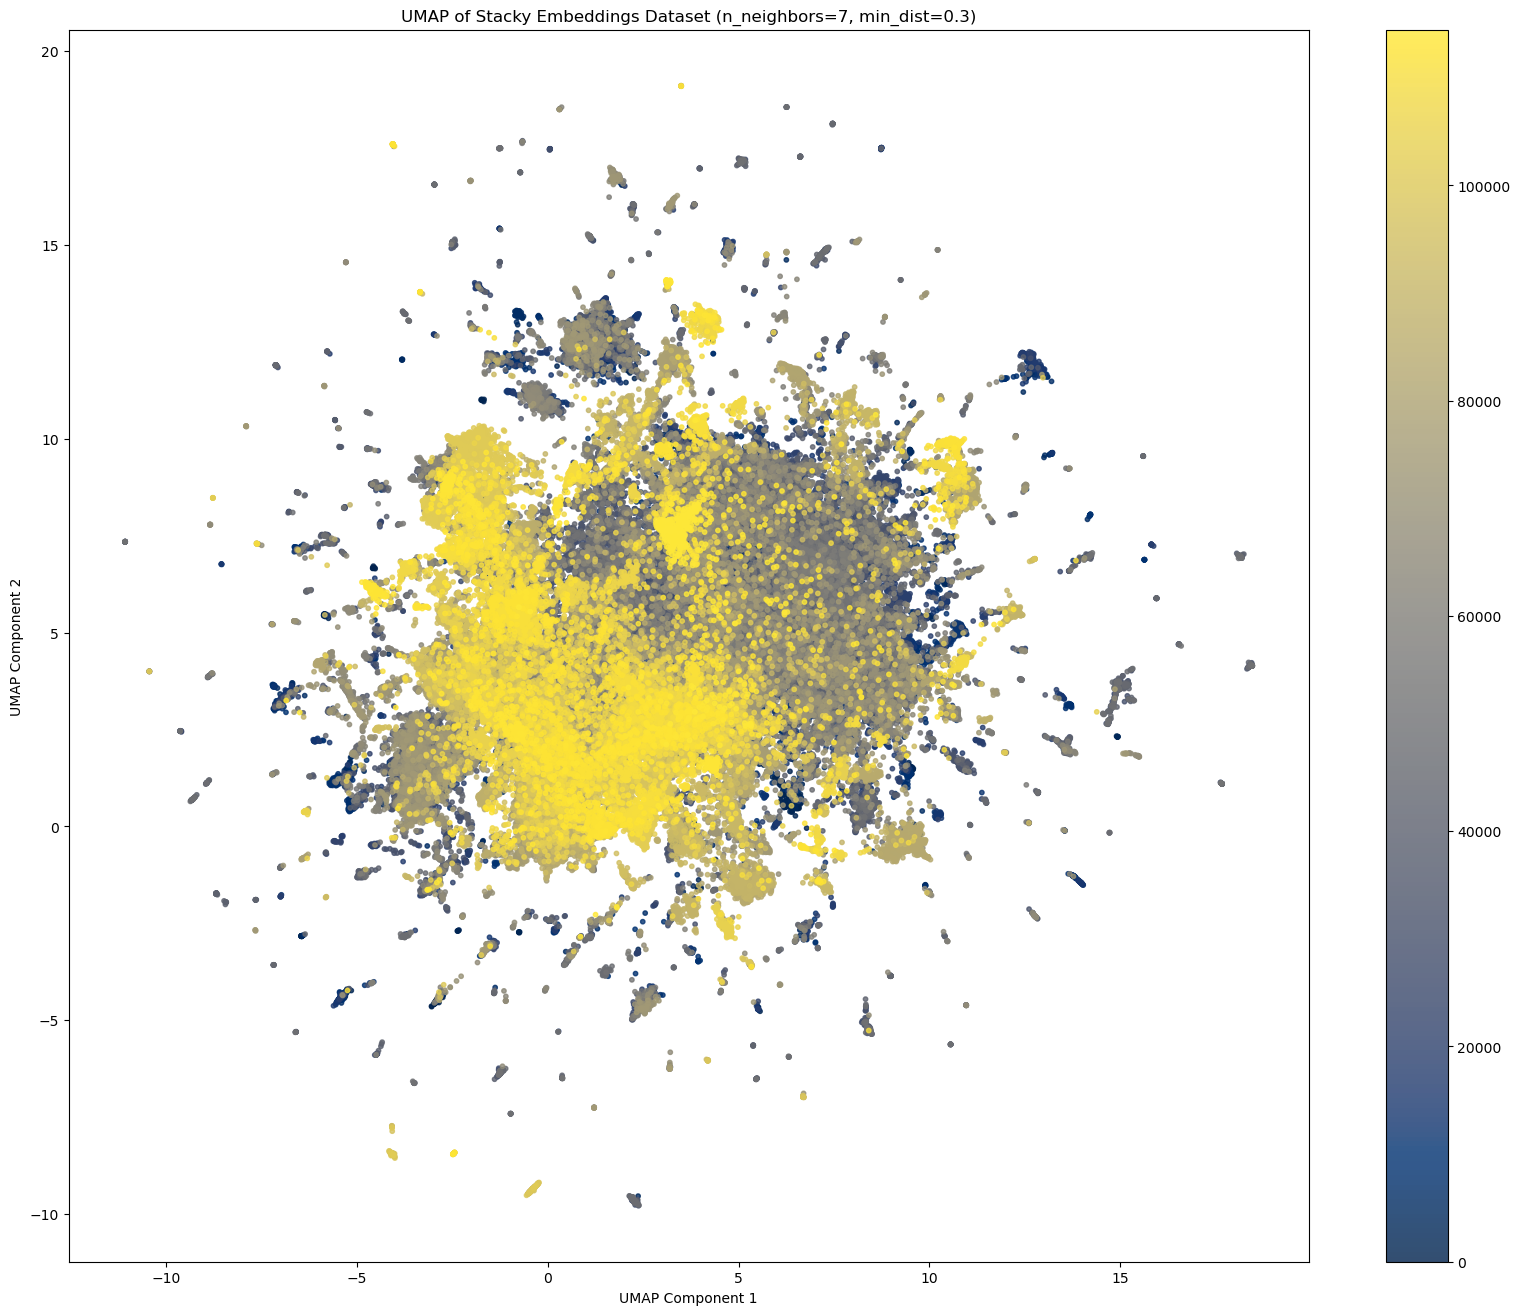

In [ ]:
# Plotting
idx = np.arange(len(embeddings_umap))
plt.figure(figsize=(20, 16))
plt.scatter(embeddings_umap[:, 0], embeddings_umap[:, 1], c=idx, s=10, alpha=0.8, cmap='cividis')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title(f'UMAP of Stacky Embeddings Dataset (n_neighbors=7, min_dist=0.3)')
plt.colorbar()
plt.show()

Relays included:
- https://relay.c.im/inbox
    - pockets of german, otherwise short social media
- https://relay.fedi.buzz/instance/zirk.us
- https://relay.fedi.buzz/tag/climate



## Generate a wordcloud of the text input!

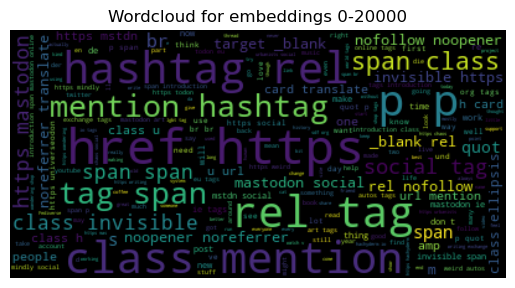

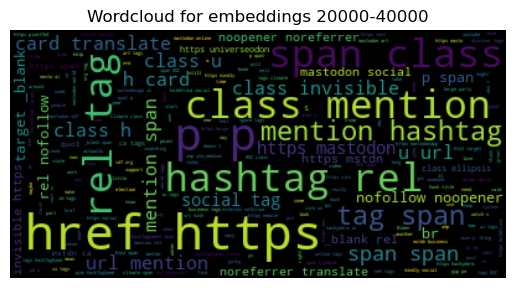

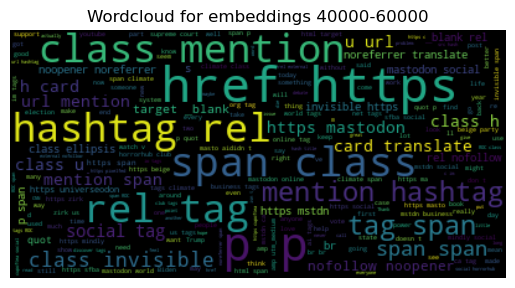

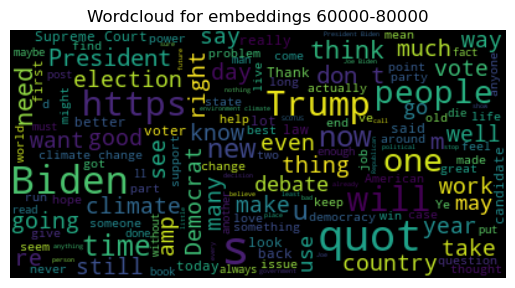

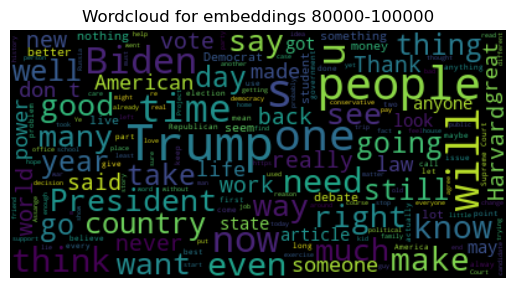

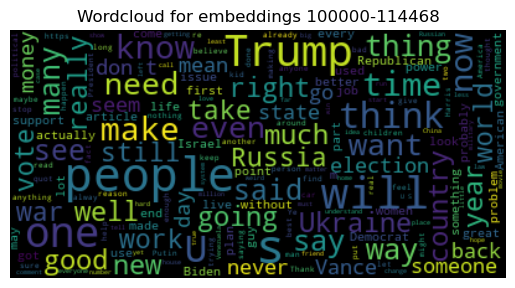

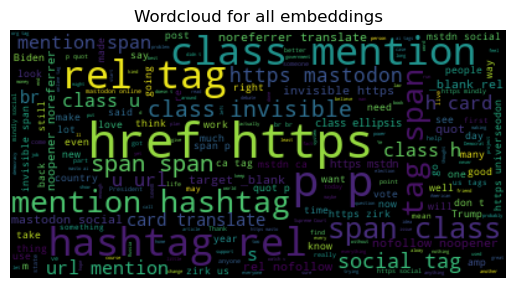

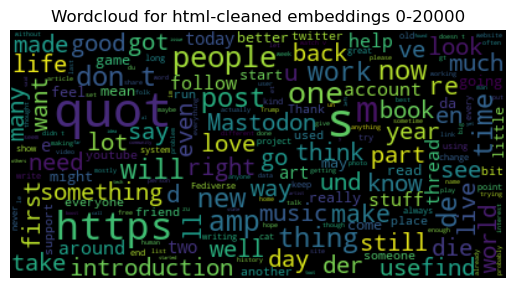

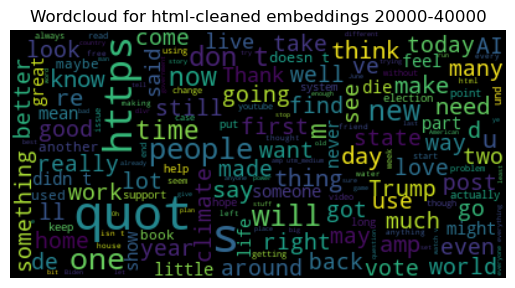

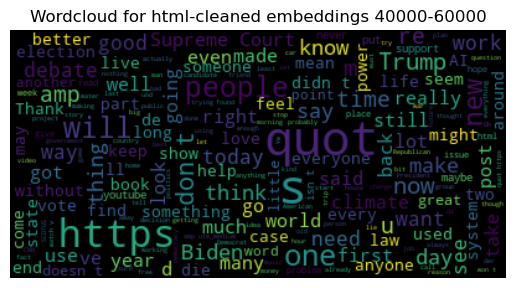

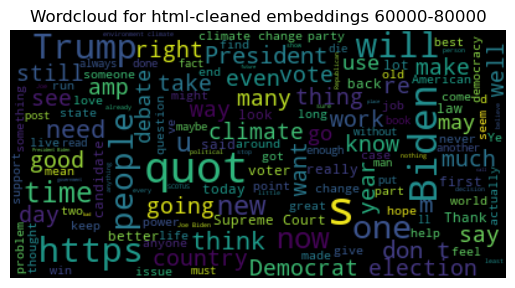

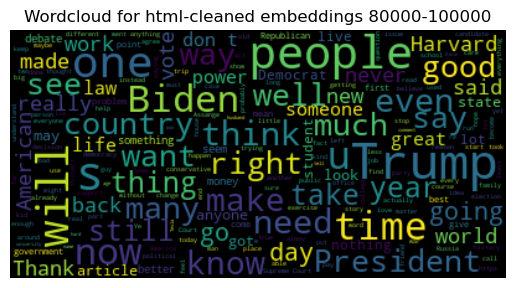

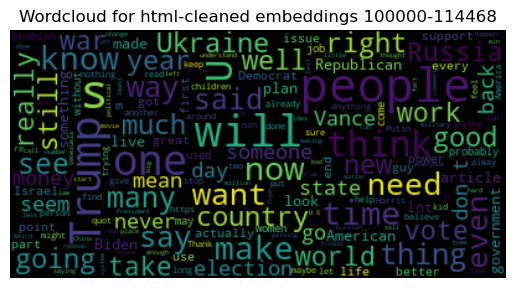

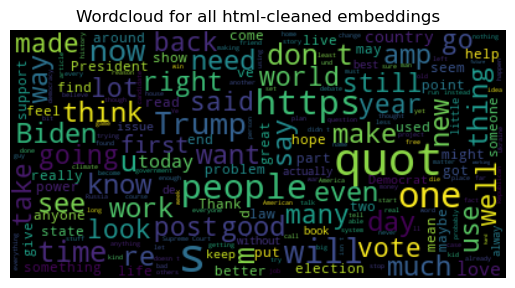

In [ ]:
from wordcloud import WordCloud

def remove_html_tags(text):
    """Remove html tags from a string"""
    import re
    clean = re.compile('<.*?>') # clear shortest matching string in angle brackets
    return re.sub(clean, '', text)

def plot_wordclouds(clean_html=False):
    #extract all the text from the embeddings into one string
    all_text = " ".join(dataset.metadata.text)
    if clean_html: all_text = remove_html_tags(all_text)

    breakpoints = np.arange(0, len(dataset.metadata.text), 20_000)
    start = 0
    for point in breakpoints[1:]:
        text = " ".join(dataset.metadata.text[start:point])
        if clean_html: text = remove_html_tags(text)

        wordcloud = WordCloud(max_font_size=40).generate(text)
        plt.figure()
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.title(f"Wordcloud for html-cleaned embeddings {start}-{point}") if clean_html else plt.title(f"Wordcloud for embeddings {start}-{point}")
        plt.axis("off")
        plt.show()
        start = point

    #also wordcloud for the final chunk of embeddings
    end_text = " ".join(dataset.metadata.text[start:])
    if clean_html: end_text = remove_html_tags(end_text)

    wordcloud = WordCloud(max_font_size=40).generate(end_text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Wordcloud for html-cleaned embeddings {start}-{len(dataset.metadata.text)}") if clean_html else plt.title(f"Wordcloud for embeddings {start}-{len(dataset.metadata.text)}")
    plt.axis("off")
    plt.show()

    # wordcloud for the full text
    wordcloud = WordCloud(max_font_size=40).generate(all_text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title("Wordcloud for all html-cleaned embeddings") if clean_html else plt.title("Wordcloud for all embeddings")
    plt.axis("off")
    plt.show()

plot_wordclouds()
plot_wordclouds(clean_html=True)


## Similar Embeddings

In [ ]:
from scipy.spatial import KDTree
# Avg dist btw cleaned/uncleaned text or collect nearest neighbors embeddings and compare text

# for 10 randomly selected embeddings, plot them red on the map with the 10 closest embeddings around them
focused_indices = np.random(np.arange(len(embeddings_umap)), 10)
print(focused_indices)

tree = KDTree(X)

In [ ]:
# finds 10-th nearest neighbors
ds, neighbors =  tree.query(embeddings_umap[focused_indices[0]], 10) 

#visualize which embeddings we're comparing
idx = np.arange(len(embeddings_umap))
plt.figure(figsize=(20, 16))

plt.scatter(embeddings_umap[:, 0], embeddings_umap[:, 1], c=idx, s=10, alpha=0.8, cmap='cividis')
plt.scatter(embeddings_umap[neighbors,0], embeddings_umap[neighbors,1], c='r', s=15)
plt.scatter(embeddings_umap[focused_indices,0], embeddings_umap[focused_indices,1], c='b', s=15)

plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title(f'UMAP of Stacky Embeddings Dataset (n_neighbors=7, min_dist=0.3)')
plt.colorbar()
plt.show()
plt.show()